In [43]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import markov_sim as markov
import json
import os
from datetime import datetime
from datetime import timedelta
from re import sub
from dateutil import  parser
from scipy.signal import periodogram
from sktime.transformations.series.outlier_detection import HampelFilter
from hampel import hampel

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['HSA_OVERRIDE_GFX_VERSION'] = '10.3.0'
os.environ['LD_LIBRARY_PATH'] = '$LD_LIBRARY_PATH:/opt/rocm-5.3.0/lib'
data_list = []


In [44]:
file = '1.145392229.json'

for line in open(file, 'r'):
    data_list.append(json.loads(line))

with open(file, 'r') as f:
    top = f.readline()
    top = json.loads(top)

runner_id = top['mc'][0]['marketDefinition']['runners'][0]['id']
runner_id_2 = top['mc'][0]['marketDefinition']['runners'][1]['id']
market_datetime = parser.parse(data_list[-1]['mc'][0]['marketDefinition']['marketTime'])
market_timestamp = datetime.timestamp(market_datetime) * 1000


def get_list(runner_id):
    # Create list for each runner
    runner_list = []
    for instance in data_list:
        if instance['pt'] > market_timestamp:
            if instance['mc'][0]['rc']:
                # Check for runner id
                temp_dict = {k: v for (k, v) in instance['mc'][0]['rc'][0].items() if v == runner_id}
                if temp_dict:
                    # Append runner info
                    runner_list.append([instance['mc'][0]['rc'][0], instance['pt']])
                elif len(instance['mc'][0]['rc']) > 1:
                    # If more than one runner
                    temp_dict_2 = {k: v for (k, v) in instance['mc'][0]['rc'][1].items() if v == runner_id}
                    if temp_dict_2:
                        runner_list.append([instance['mc'][0]['rc'][1], instance['pt']])
    return runner_list


def convert_odds(runner_list):
    # Convert to back/lay/last traded odds

    list = []

    for item in runner_list:
        if 'ltp' in item[0]:
            list.append([item[0]['ltp'], item[1]])

    del list[-1]
    arr = np.array(list)
    arr = arr[arr[:, 0] != 0]
    implied_odds = np.array([1 / arr[:, 0], arr[:, 1]]).T

    return implied_odds


# Find avg ltp odds
def odds_avg(runner_1, runner_2):
    if runner_1[-1, 1] > runner_2[-1, 1]:
        if runner_1[1, 1] > runner_2[1, 1]:
            timestamps = np.arange(round(runner_2[1, 1], -2), round(runner_1[-1, 1] + 1, -2), 100)
        else:
            timestamps = np.arange(round(runner_1[1, 1], -2), round(runner_1[-1, 1] + 1, -2), 100)
    else:
        if runner_1[1, 1] > runner_2[1, 1]:
            timestamps = np.arange(round(runner_2[1, 1], -2), round(runner_2[-1, 1] + 1, -2), 100)
        else:
            timestamps = np.arange(round(runner_1[1, 1], -2), round(runner_2[-1, 1] + 1, -2), 100)

    odds = np.zeros(np.shape(timestamps))
    df_timestamps = pd.Series(timestamps)

    df_datetime = pd.to_datetime(df_timestamps, unit='ms')

    df = pd.DataFrame({'runner 1': odds, '1 - runner 2': odds}, index=df_datetime)

    for index, time in enumerate(runner_1[:, 1]):
        df['runner 1'].loc[pd.to_datetime(round(time, -2), unit='ms')] = runner_1[index, 0]

    for index, time in enumerate(runner_2[:, 1]):
        df['1 - runner 2'].loc[pd.to_datetime(round(time, -2), unit='ms')] = 1 - runner_2[index, 0]

    df.replace(0, np.nan, inplace=True)
    df.interpolate(method='time', limit_direction='both', inplace=True)
    df['avg'] = df.mean(axis=1)
    df = df.resample('500ms').last()
    print(df)
    return df

def get_best_pricevol(runner_list, price, vol):
# Function to get best lay and back information
    back_list = []
    lay_list = []

    back_vol = []
    lay_vol = []

    for item in runner_list:
        if 'atl' in item[0]:
            if len(item[0]['atl']) > 1:
                temp = []
                for i in item[0]['atl']:
                    if i[1] != 0:
                        temp.append(i[0])
                if temp:
                    temp = np.array(temp)
                    back_list.append([temp.min(), item[1]])
                    back_vol.append([item[0]['atl'][temp.argmax()][1], item[1]])
            else:
                if item[0]['atl'][0][1] != 0:
                    back_list.append([item[0]['atl'][0][0], item[1]])
                    back_vol.append([item[0]['atl'][0][1], item[1]])

    for item in runner_list:
        if 'atb' in item[0]:
            if len(item[0]['atb']) > 1:
                temp = []
                for i in item[0]['atb']:
                    if i[1] != 0:
                        temp.append(i[0])
                if temp:
                    temp = np.array(temp)
                    lay_list.append([temp.max(), item[1]])
                    lay_vol.append([item[0]['atb'][temp.argmax()][1], item[1]])
            else:
                if item[0]['atb'][0][1] != 0:
                    lay_list.append([item[0]['atb'][0][0], item[1]])
                    lay_vol.append([item[0]['atb'][0][1], item[1]])

    del back_list[-1], lay_list[-1], back_vol[-1], lay_vol[-1]

    back_vol_arr = np.array(back_vol)
    lay_vol_arr = np.array(lay_vol)
    back_arr = np.array(back_list)
    lay_arr = np.array(lay_list)

    back_series = pd.Series(back_arr[:, 0], index=pd.to_datetime(back_arr[:, 1], unit='ms'))
    lay_series = pd.Series(lay_arr[:, 0], index=pd.to_datetime(lay_arr[:, 1], unit='ms'))
    back_vol_series = pd.Series(back_vol_arr[:, 0], index=pd.to_datetime(back_vol_arr[:, 1], unit='ms'))
    lay_vol_series = pd.Series(lay_vol_arr[:, 0], index=pd.to_datetime(lay_vol_arr[:, 1], unit='ms'))
# Apply hampel filter to remove outliers
    back_outliers = hampel(back_series, window_size=80)
    lay_outliers = hampel(lay_series, window_size=80)
    back_vol_outliers = hampel(back_vol_series, window_size=15)
    lay_vol_outliers = hampel(lay_vol_series, window_size=15)

    back_arr = np.delete(back_arr, back_outliers, axis=0)
    lay_arr = np.delete(lay_arr, lay_outliers, axis=0)
    back_vol_arr = np.delete(back_vol_arr, back_vol_outliers, axis=0)
    lay_vol_arr = np.delete(lay_vol_arr, lay_vol_outliers, axis=0)

    if price and not vol:
        return back_arr, lay_arr
    elif vol and not price:
        return back_vol_arr, lay_vol_arr

    return back_arr, lay_arr, back_vol_arr, lay_vol_arr

def best_available_df(runner_list, start, end):
# Get back and lay information and calculate spread and price up probability
    end_time = end + pd.Timedelta(60, 'sec')
    df_datetime = pd.date_range(start, end_time, freq='100ms')
    df_datetime = df_datetime.floor('100ms')
    dt_shape = np.zeros(df_datetime.shape)

    back_arr, lay_arr, back_vol_arr, lay_vol_arr = get_best_pricevol(runner_list, True, True)

    df = pd.DataFrame({'back': dt_shape, 'lay': dt_shape, 'back_vol': dt_shape, 'lay_vol': dt_shape}, index=df_datetime)

    for index, time in enumerate(back_arr[:, 1]):
        df['back'].loc[pd.to_datetime(round(time, -2), unit='ms')] = back_arr[index, 0]
    for index, time in enumerate(lay_arr[:, 1]):
        df['lay'].loc[pd.to_datetime(round(time, -2), unit='ms')] = lay_arr[index, 0]

    for index, time in enumerate(back_vol_arr[:, 1]):
        df['back_vol'].loc[pd.to_datetime(round(time, -2), unit='ms')] = back_vol_arr[index, 0]
    for index, time in enumerate(lay_vol_arr[:, 1]):
        df['lay_vol'].loc[pd.to_datetime(round(time, -2), unit='ms')] = lay_vol_arr[index, 0]

    df.replace(0, np.nan, inplace=True)
    df.interpolate(method='time', limit_direction='both', inplace=True)

    _500ms = df.index.floor('500ms')
    idx_back = df.groupby(_500ms)['back'].idxmin()
    idx_lay = df.groupby(_500ms)['lay'].idxmax()
    print(idx_back)
    df = df.resample('500ms').mean().assign(back=df.loc[idx_back]['back'].values,
                                            back_vol=df.loc[idx_back]['back_vol'].values,
                                            lay=df.loc[idx_lay]['lay'].values,
                                            lay_vol=df.loc[idx_lay]['lay_vol'].values)

    df = df.rolling('60S').mean().shift(int(- 60 / .5))
    df = df.loc[start:end]
    df['back-lay avg'] = df[['back', 'lay']].mean(axis=1)
    df['spread'] = df['back'] - df['lay']
    df['uncertainty'] = df['spread'] / df['back-lay avg']
    df_pup = df['back_vol'] / ( df['back_vol'] + df['lay_vol'] )
    df_pup.name = 'pup'
    df = pd.concat([df, df_pup], axis=1)
    df.fillna(method='ffill', inplace=True)

    return df



def calc_score(p, q, game_score, set_score, match_score, implied_odds):
    for m in implied_odds:
        # if current_score is '0-0':
        #     s1 = '15-0'
        #     s2 = '0-15'
        # elif current_score is '15-0':
        #     s1 = '30-0'
        #     s2 = '15-15'
        # elif current_score is '0-15':
        #     s1 = '15-15'
        #     s2 = '0-30'
        # elif current_score is '15-15':
        #     s1 = '30-15'
        #     s2 = '15-30'
        # elif current_score is '30-0':
        #     s1 = '40-0'
        #     s2 = '30-15'
        # elif current_score is '0-30':
        #     s1 = '15-30'
        #     s2 = '0-40'
        # elif current_score is '30-15':
        #     s1 = '40-15'
        #     s2 = '30-30(DEUCE)'
        # elif current_score is '15-30':
        #     s1 = '30-30(DEUCE)'
        #     s2 = '15-40'
        # elif current_score is '30-30(DEUCE)':
        #     s1 = '40-30(A-40)'
        #     s2 = '30-40(40-A)'
        # elif current_score is '40-15':
        #     s1 = 'Win'
        #     s2 = '40-30(A-40)'
        # elif current_score is '15-40':
        #     s1 = '30-40(40-A)'
        #     s2 = 'Lose'
        # elif current_score is '30-40(40-A)':
        #     s1 = '30-30(DEUCE)'
        #     s2 = 'Lose'
        # elif current_score is '40-30(A-40)':
        #     s1 = 'WIN'
        #     s2 = '30-30(DEUCE)'
        m1 = markov.tennis_model(p, q, )
        m2 =
        if m > m1:
            s = s1
        elif = m > m2:
            s = s2



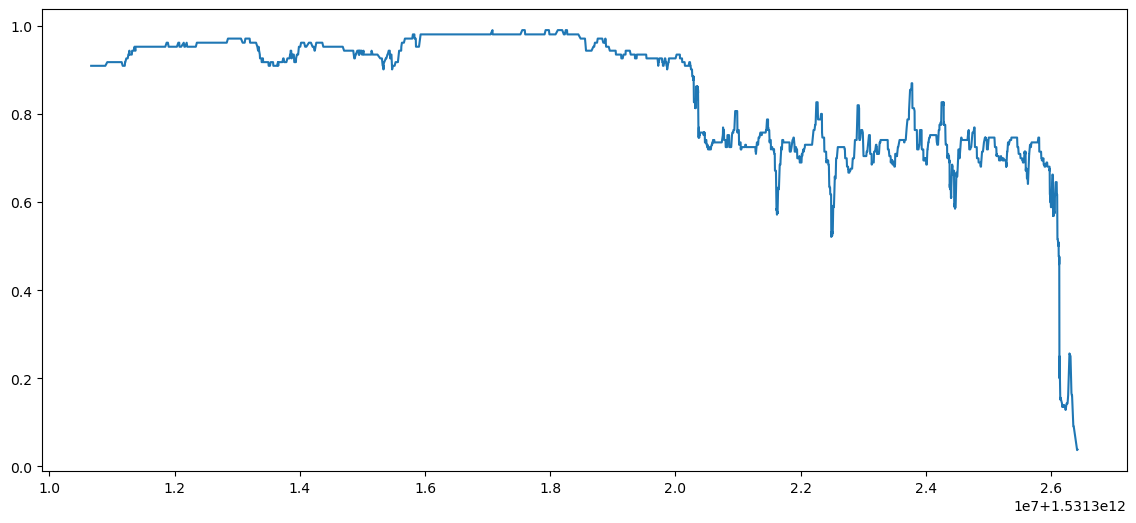

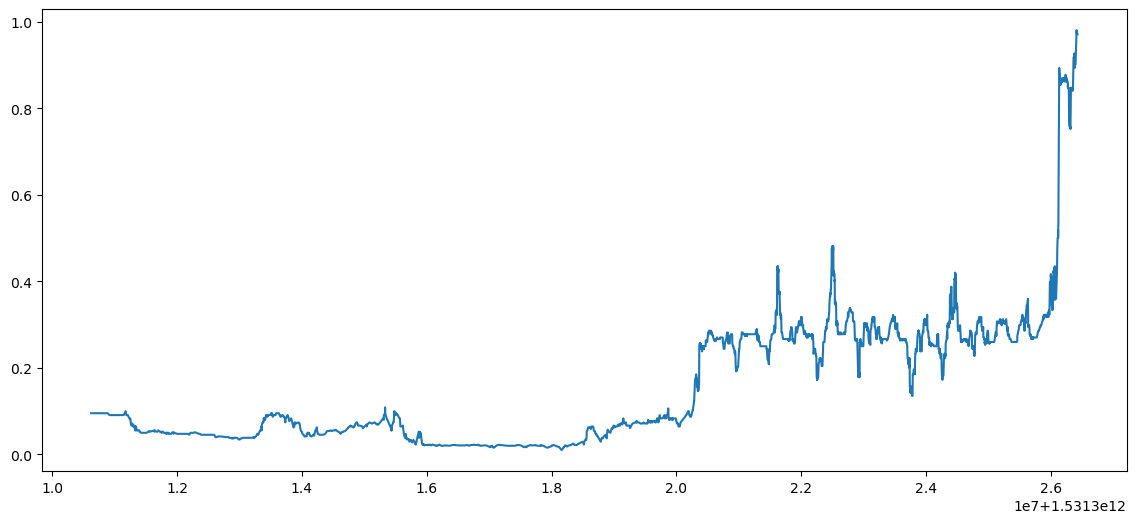

In [45]:
runner_list_1 = get_list(runner_id)
runner_list_2 = get_list(runner_id_2)
runner_odds_1 = convert_odds(runner_list_1)
runner_odds_2 = convert_odds(runner_list_2)
plt.figure(figsize=(14,6))
plt.plot(runner_odds_1[:, 1], runner_odds_1[:, 0])
plt.figure(figsize=(14,6))
plt.plot(runner_odds_2[:, 1], runner_odds_2[:, 0])


In [46]:
df = odds_avg(runner_odds_1, runner_odds_2)

                         runner 1  1 - runner 2       avg
2018-07-11 12:04:03.000  0.909091      0.904762  0.906926
2018-07-11 12:04:03.500  0.909091      0.904762  0.906926
2018-07-11 12:04:04.000  0.909091      0.904762  0.906926
2018-07-11 12:04:04.500  0.909091      0.904762  0.906926
2018-07-11 12:04:05.000  0.909091      0.904762  0.906926
...                           ...           ...       ...
2018-07-11 16:27:02.000  0.038462      0.029126  0.033794
2018-07-11 16:27:02.500  0.038462      0.029126  0.033794
2018-07-11 16:27:03.000  0.038462      0.029126  0.033794
2018-07-11 16:27:03.500  0.038462      0.029126  0.033794
2018-07-11 16:27:04.000  0.038462      0.029126  0.033794

[31563 rows x 3 columns]


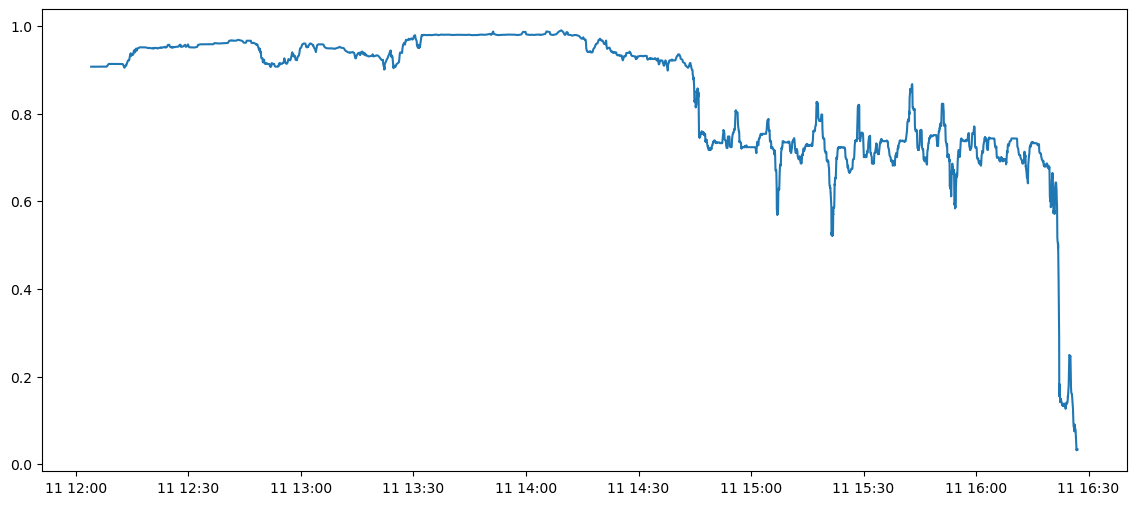

In [47]:
plt.figure(figsize=(14,6))
plt.plot(df['avg'])

In [48]:
start = df.first_valid_index()
end = df.last_valid_index()
df_runner_1 = best_available_df(runner_list_1, start, end)
print(df_runner_1)

2018-07-11 12:04:03.000   2018-07-11 12:04:03.000
2018-07-11 12:04:03.500   2018-07-11 12:04:03.500
2018-07-11 12:04:04.000   2018-07-11 12:04:04.000
2018-07-11 12:04:04.500   2018-07-11 12:04:04.500
2018-07-11 12:04:05.000   2018-07-11 12:04:05.000
                                    ...          
2018-07-11 16:28:02.000   2018-07-11 16:28:02.000
2018-07-11 16:28:02.500   2018-07-11 16:28:02.500
2018-07-11 16:28:03.000   2018-07-11 16:28:03.000
2018-07-11 16:28:03.500   2018-07-11 16:28:03.500
2018-07-11 16:28:04.000   2018-07-11 16:28:04.000
Name: back, Length: 31683, dtype: datetime64[ns]
                              back       lay      back_vol       lay_vol  \
2018-07-11 12:04:03.000   1.117026  1.092353  71151.823388  30761.288425   
2018-07-11 12:04:03.500   1.117026  1.092416  71151.177805  30102.055690   
2018-07-11 12:04:04.000   1.117026  1.092470  71150.406128  29509.818643   
2018-07-11 12:04:04.500   1.117026  1.092516  71149.508357  28984.577284   
2018-07-11 12:04:05.0

In [49]:
df_runner_2 = best_available_df(runner_list_2, start, end)
print(df_runner_2)

2018-07-11 12:04:03.000   2018-07-11 12:04:03.000
2018-07-11 12:04:03.500   2018-07-11 12:04:03.500
2018-07-11 12:04:04.000   2018-07-11 12:04:04.400
2018-07-11 12:04:04.500   2018-07-11 12:04:04.900
2018-07-11 12:04:05.000   2018-07-11 12:04:05.400
                                    ...          
2018-07-11 16:28:02.000   2018-07-11 16:28:02.000
2018-07-11 16:28:02.500   2018-07-11 16:28:02.500
2018-07-11 16:28:03.000   2018-07-11 16:28:03.000
2018-07-11 16:28:03.500   2018-07-11 16:28:03.500
2018-07-11 16:28:04.000   2018-07-11 16:28:04.000
Name: back, Length: 31683, dtype: datetime64[ns]
                              back       lay      back_vol      lay_vol  \
2018-07-11 12:04:03.000  11.852891  8.777281    447.453017   375.070348   
2018-07-11 12:04:03.500  11.840391  8.793115    450.144598   391.127714   
2018-07-11 12:04:04.000  11.828094  8.808948    452.795575   407.188212   
2018-07-11 12:04:04.500  11.816814  8.824781    455.440937   423.251842   
2018-07-11 12:04:05.000  1

                         ltp odds  back lay odds
2018-07-11 12:04:03.000  0.906926       0.904143
2018-07-11 12:04:03.500  0.906926       0.904138
2018-07-11 12:04:04.000  0.906926       0.904135
2018-07-11 12:04:04.500  0.906926       0.904137
2018-07-11 12:04:05.000  0.906926       0.904142
...                           ...            ...
2018-07-11 16:27:02.000  0.033794       0.091991
2018-07-11 16:27:02.500  0.033794       0.091933
2018-07-11 16:27:03.000  0.033794       0.091879
2018-07-11 16:27:03.500  0.033794       0.091829
2018-07-11 16:27:04.000  0.033794       0.091782

[31563 rows x 2 columns]


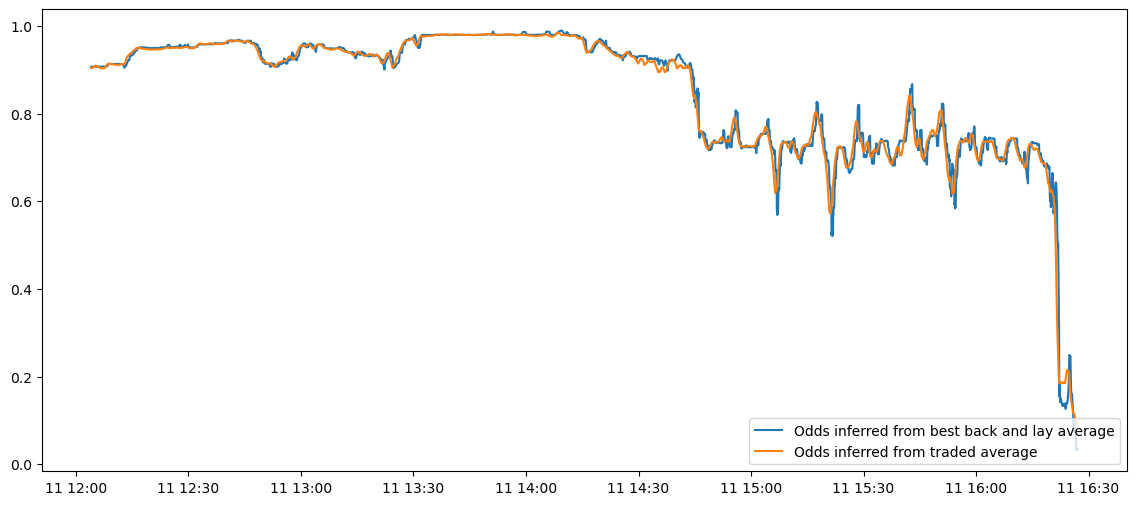

In [50]:
df_avg = df['avg']
df_blodds = ( 1 / df_runner_1['back-lay avg'] + 1 - 1 / df_runner_2['back-lay avg'] ) / 2
df_odds = pd.concat([df_avg, df_blodds], axis=1)
df_odds.columns = ['ltp odds', 'back lay odds']
print(df_odds)
plt.figure(figsize=(14,6))
plt.plot(df_odds)
plt.legend(['Odds inferred from best back and lay average', 'Odds inferred from traded average'], loc='lower right')

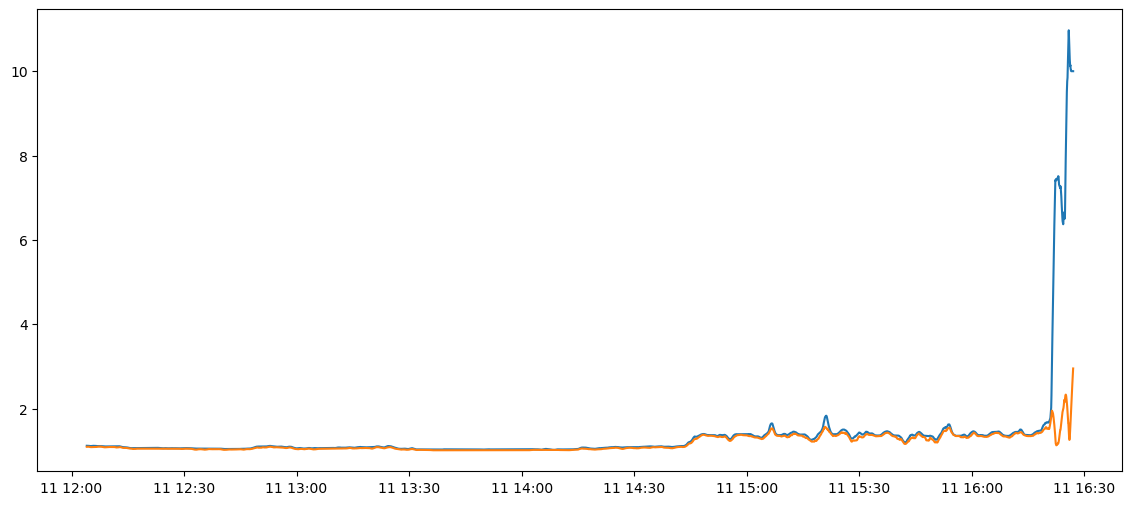

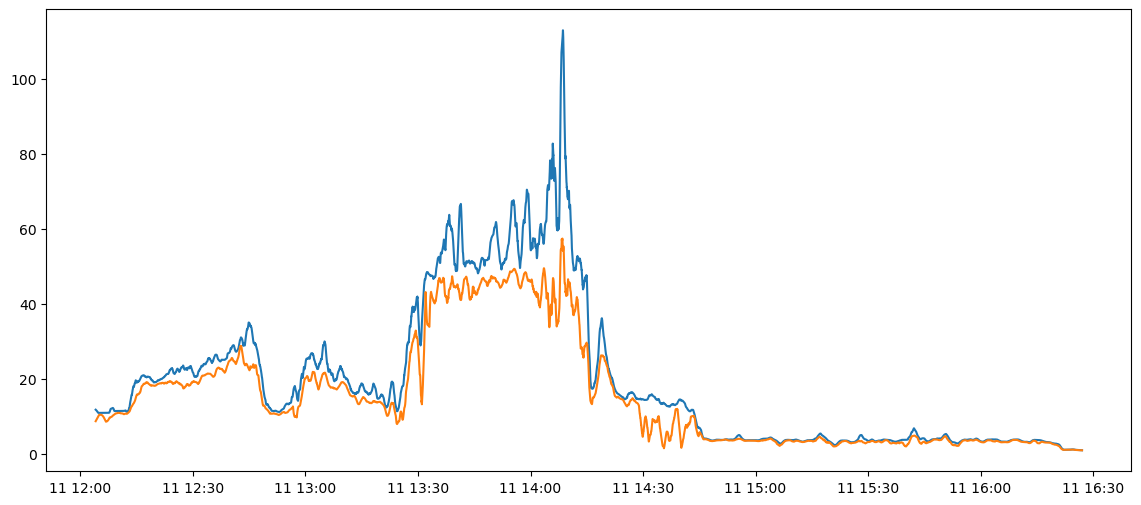

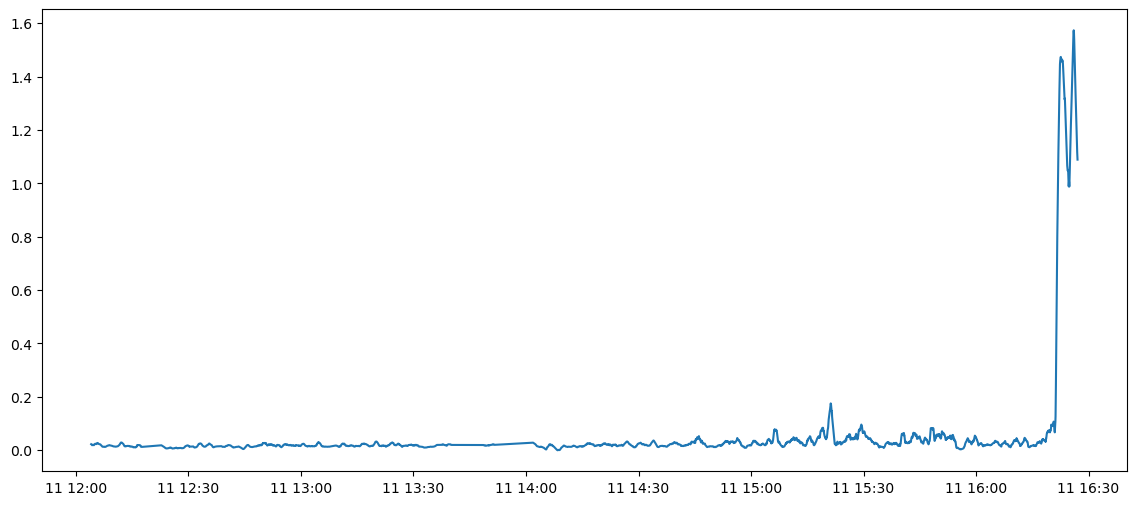

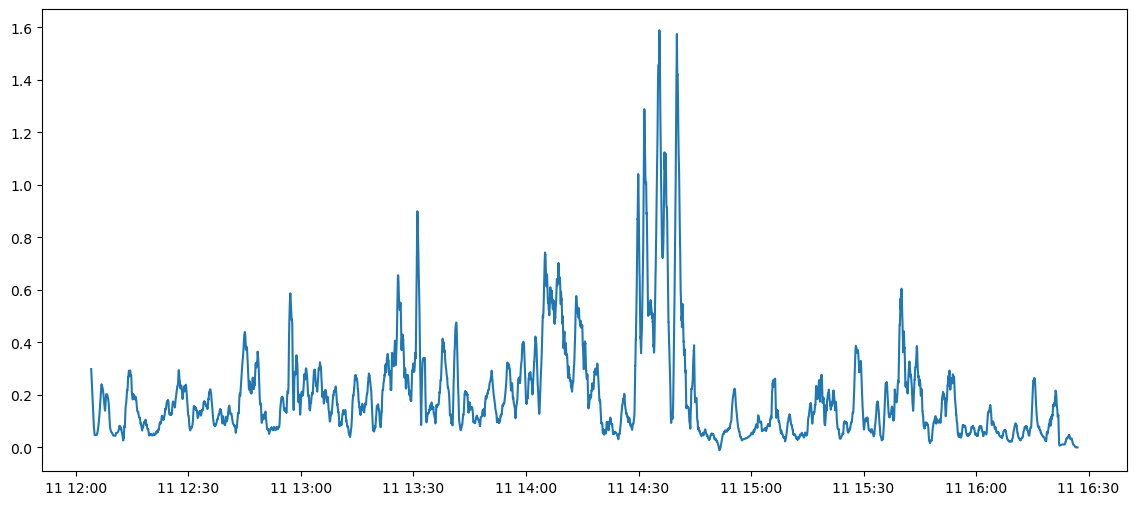

In [51]:
plt.figure(figsize=(14,6))
plt.plot(df_runner_1[['back','lay']])
plt.figure(figsize=(14,6))
plt.plot(df_runner_2[['back','lay']])
plt.figure(figsize=(14,6))
plt.plot(df_runner_1[['uncertainty']])
plt.figure(figsize=(14,6))
plt.plot(df_runner_2[['uncertainty']])

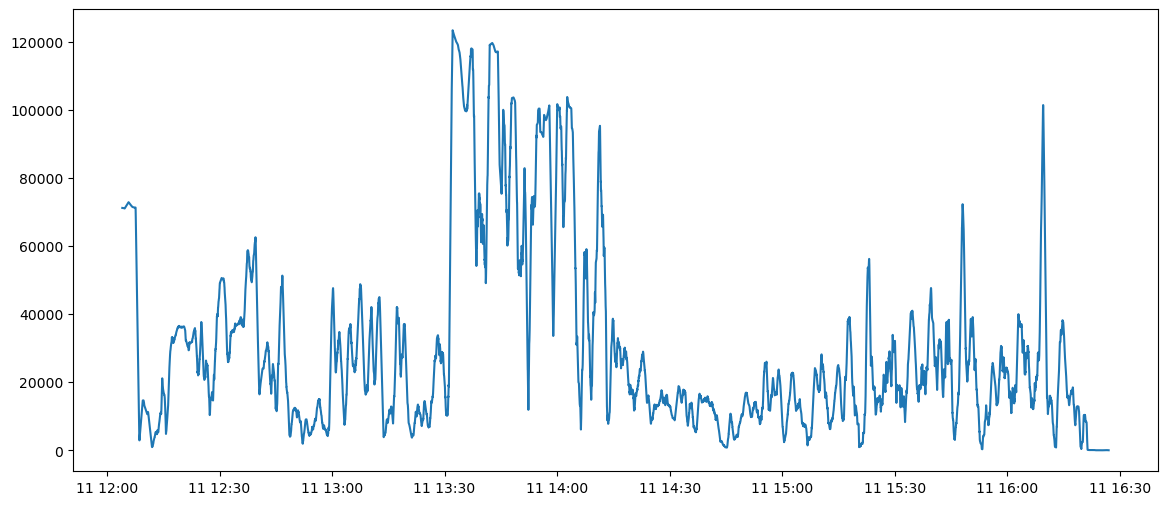

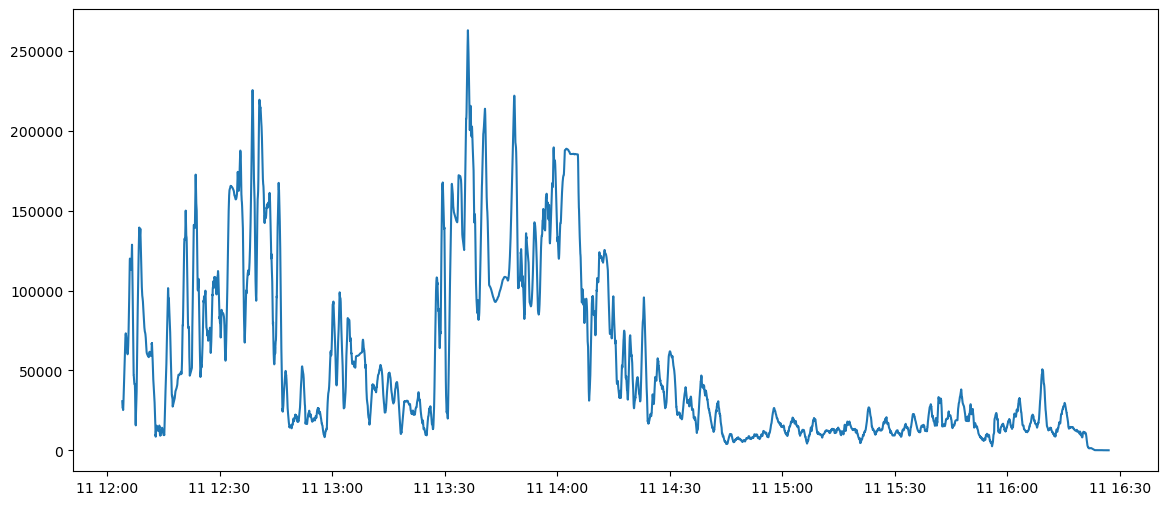

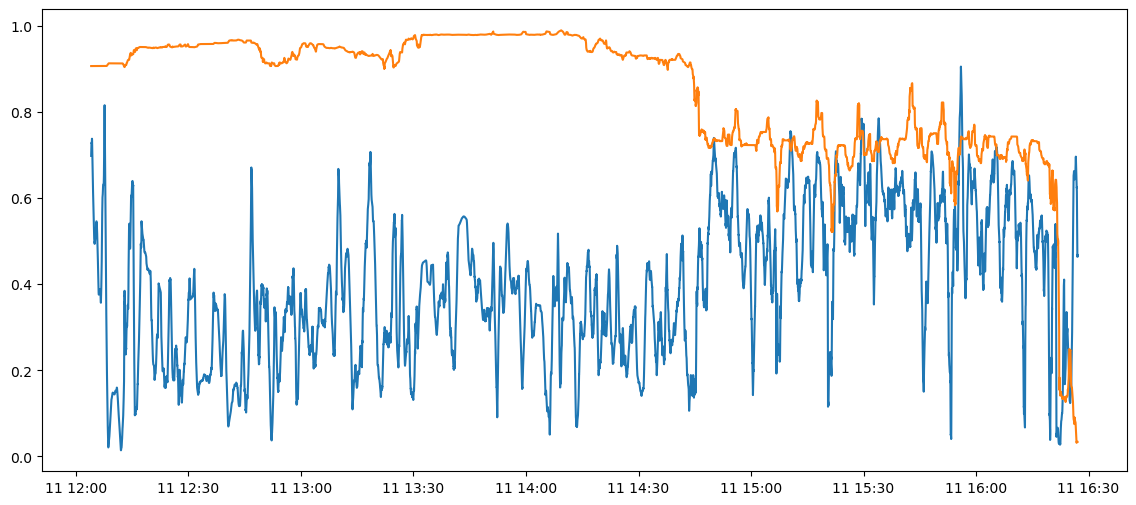

In [52]:
plt.figure(figsize=(14,6))
plt.plot(df_runner_1[['back_vol']])
plt.figure(figsize=(14,6))
plt.plot(df_runner_1[['lay_vol']])
plt.figure(figsize=(14,6))
plt.plot(df_runner_1[['pup']])
plt.plot(df_odds['ltp odds'])

                         lpt odds  r1 spread    r1 pup  r2 spread    r2 pup
2018-07-11 12:04:03.000  0.906926   0.022335  0.698162   0.298166  0.544000
2018-07-11 12:04:03.500  0.906926   0.022277  0.702705   0.295372  0.535076
2018-07-11 12:04:04.000  0.906926   0.022228  0.706837   0.292595  0.526516
2018-07-11 12:04:04.500  0.906926   0.022186  0.710542   0.289903  0.518316
2018-07-11 12:04:05.000  0.906926   0.022153  0.713806   0.287297  0.510454
...                           ...        ...       ...        ...       ...
2018-07-11 16:27:02.000  0.033794   1.097119  0.465991   0.000000  0.873379
2018-07-11 16:27:02.500  0.033794   1.094813  0.467110   0.000000  0.879861
2018-07-11 16:27:03.000  0.033794   1.092648  0.468029   0.000000  0.886190
2018-07-11 16:27:03.500  0.033794   1.090625  0.468748   0.000000  0.892490
2018-07-11 16:27:04.000  0.033794   1.088743  0.464903   0.000000  0.901850

[31563 rows x 5 columns]


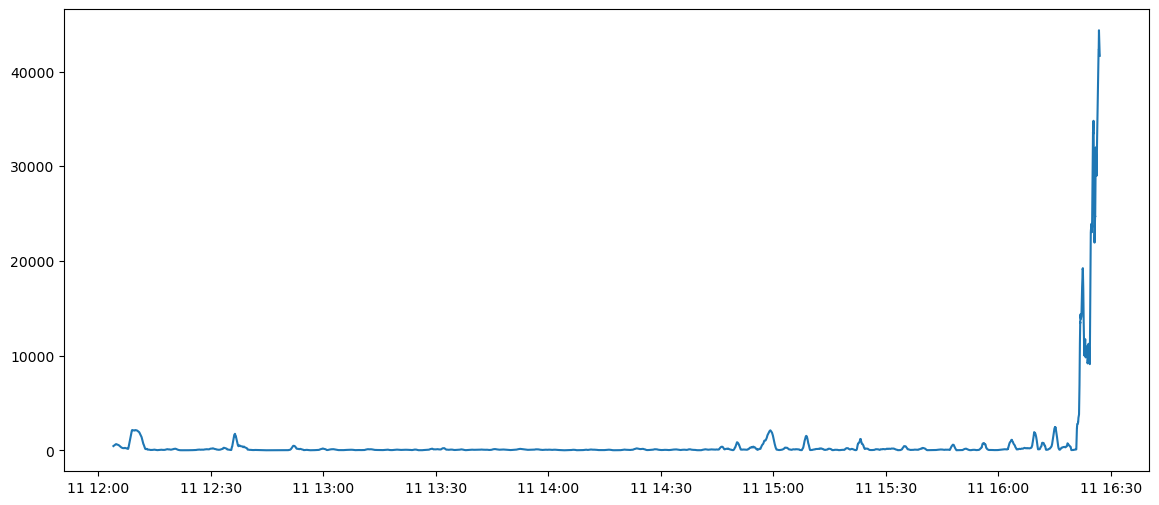

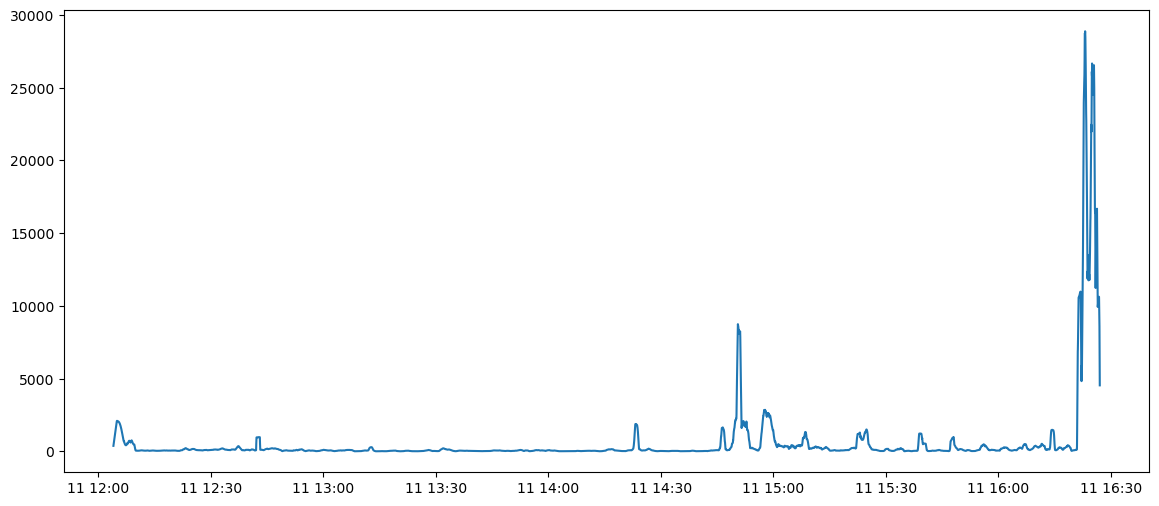

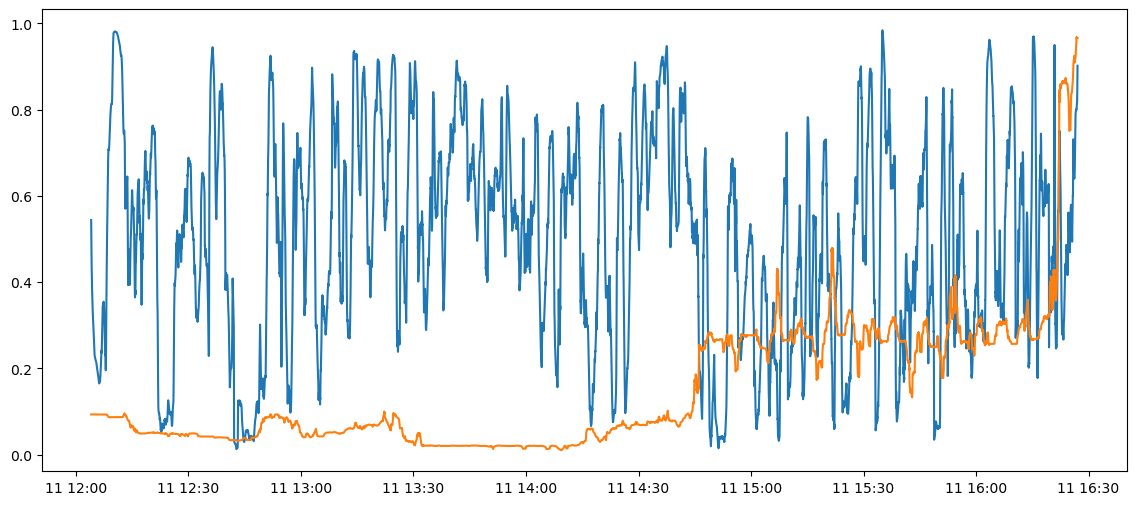

In [53]:
plt.figure(figsize=(14,6))
plt.plot(df_runner_2[['back_vol']])
plt.figure(figsize=(14,6))
plt.plot(df_runner_2[['lay_vol']])
plt.figure(figsize=(14,6))
plt.plot(df_runner_2[['pup']])
plt.plot(1 - df_odds['ltp odds'])
df_total = pd.DataFrame({'lpt odds': df_odds['ltp odds'], 'r1 spread': df_runner_1['uncertainty'], 'r1 pup': df_runner_1['pup'], 'r2 spread': df_runner_2['uncertainty'], 'r2 pup': df_runner_2['pup']}, index=df_odds.index)
print(df_total)
df_total.to_csv('Data/1.csv')